# Introdução

Objetivos:

+ Conduzir buscas na base do [Semantic Scholar](https://www.semanticscholar.org/) utilizando o wrapper [S2Query](https://github.com/BecomeAllan/S2Query), desenvolvido pela equipe do LAMFO no escopo de outro projeto de pesquisa recente.
+ Utilizar o modelo [ML-SLRC](https://github.com/BecomeAllan/ML-SLRC/blob/main/Meta_learning_EFL.ipynb) para auxiliar o processo de inclusão e exclusão de artigos na revisão sistemática de literatura.

# Dependências


In [1]:
%%capture
!pip install S2query==1.0.3.2
!pip install transformers==4.16.2
!pip install torchmetrics==0.8.0
!git lfs install
!git clone https://huggingface.co/becomeallan/ML-SLRC
!pip install crossrefapi

# !pip install matplotlib==3.5.1

In [2]:
from itertools import chain
import numpy as np
import pandas as pd

import ipywidgets as widgets
from ipywidgets import Layout
from IPython.display import HTML, display, clear_output, Markdown

%matplotlib inline
import torch.nn.functional as F
import torch.nn as nn
import math
import torch
import time
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.manifold import TSNE
from copy import deepcopy, copy
import seaborn as sns
import matplotlib.pylab as plt
from pprint import pprint
import shutil
import datetime
import re
import json
from pathlib import Path
from crossref.restful import Works
import requests

import sys

sys.path.append("/content/ML-SLRC/")

path = "/content/ML-SLRC/"

model_path = path + "model.pt"
info_path = path + "Info.json"

from Util_funs import train_loop, prepare_data, SLR_Classifier, Encoder, SLR_DataSet

# Dispositivo utilizado
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Carregamento do modelo e demais informações do modelo (meta info)
model = torch.load(model_path)
with open(info_path, "r") as f:
    Info = json.load(f)

# Configuração (meta info)
Info["tokenizer"] = AutoTokenizer.from_pretrained(Info["model"], do_lower_case=True)
Info["threshold"] = 0.9
Info["inner_update_step_eval"] = 4
Info["inner_print"] = 1
Info["inner_batch_size"] = 4
Info['inner_update_step'] = 4
Info['inner_update_lr'] = 0.00005
Info['pos_weight'] = 2.5
Info["weight_decay"] = 0.85

# Função de Loss
model.loss_fn = nn.BCEWithLogitsLoss(reduction = 'mean',
                                        pos_weight=torch.FloatTensor([Info['pos_weight']]))


Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/223k [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Requisições ao Semantic Scholar

Para realizar a pesquisa, duas funções podem ser utilizadas:

+ `SearcherAPI`: Pesquisar através da API do Semantic Scholar.
+ `SearcherWeb`: Pesquisar raspando o site do Semantic Scholar (scraping).

Dentro das funções de pesquisa, as palavras-chave devem ser especificadas utilizando **aspas simples**: `'keyword'`. Além disso, os sinais `+` e `-` podem ser usados para incluir e excluir, respectivamente, palavras-chave da pesquisa, e não deve haver espaço entre os sinais.

Exemplo: `'artificial intelligence'+'Deep Learning'-'Biology'`

## Usando a API para procurar dados

Dentro dos parâmetros disponíveis:

+ `Query`: Palavras de pesquisa como títulos ou palavras-chave
+ `Number of papers`: Número de resultados a serem retornados, até um máximo de 10.000.

Ao fornecer esses parâmetros, use o botão `Search` para realizar a pesquisa. Uma vez finalizada, os botões `Export Articles` e `Export All` salvarão os dados, considerando apenas artigos científicos ou todos os dados obtidos, respectivamente.

+ `Export Articles` salva como .csv: `data_API_Articles.csv`.
+ `Export All` salva como .csv: `data_API.csv`.

In [3]:
# @title SearcherAPI
from S2query import S2paperAPI
from multiprocessing import Pool

# Search interface using SS API
class SearcherAPI:
    def __init__(self):
        # Creates data fetching object
        self.obj = S2paperAPI()
        self.find = False
        self.save_b = widgets.Button(description="Export Articles")
        self.save_b.on_click(self.post_processing)
        self.save_all_b = widgets.Button(description="Export All")
        self.save_all_b.on_click(self.save_data)

        # Creating buttons and textbox
        self.search_b = widgets.Button(description="Search")
        self.search_text = widgets.Textarea(
            description=" : Query",
            value="'artificial intelligence'+'Deep Learning'-'Biology'",
            placeholder="Type something",
            layout=Layout(
                width="50%", height="60px", display="flex", flex_flow="row-reverse"
            ),
            # description=':',
            disabled=False,
        )

        self.number_papers = widgets.IntText(
            value=100,
            min=2,
            # layout = widgets.Layout(width='180px'),
            style={"description_width": "initial"},
            layout=Layout(width="180px", display="flex", flex_flow="row-reverse"),
            description=" Number of papers",
            disabled=False,
        )

        # self.leftbox = widgets.HBox([self.search_text])
        self.rightbox = widgets.VBox(
            [self.search_text, self.number_papers, self.search_b]
        )

        # self.hbox = widgets.HBox([self.leftbox, self.rightbox])
        self.save_h = widgets.HBox([self.save_b, self.save_all_b])

        # On click function
        self.search_b.on_click(self.search_button)

    # Search button
    def search_button(self, p):
        print(self.search_text.value)
        # Searches data
        self.obj.get(
            self.search_text.value,
            n=self.number_papers.value,
            fields = ['externalIds', 'paperId', 'url', 'title', \
                        'abstract', 'venue', 'year', 'referenceCount', \
                        'citationCount', 'influentialCitationCount', \
                        'isOpenAccess', 'fieldsOfStudy', 'authors']
        )

        # Saves data found
        self.data = self.obj.all
        self.extract_info()

        # self.data

        self.find = True
        self.__call__()


    def extract_info(self):
        self.data = self.data.rename(columns={"externalIds": "doi"})
        doi = [d.get("DOI") for d in self.data.doi]
        self.data["doi"] = doi
        null = self.data.doi.isnull().values
        self.data = self.data.drop(self.data[null].index)
        self.data = self.data[self.data.doi != ""]
        self.data['authors'] = self.data.authors.map(lambda author: [contex['name']  for contex in author ] if len(author) != 0 else author)
        self.data = self.data[self.data.doi != ""]

    def doi2bib(self, doi):
        """
        Return a bibTeX string of metadata for a given DOI.
        """

        url = "http://dx.doi.org/" + doi

        headers = {"accept": "application/x-bibtex"}
        r = requests.get(url, headers = headers)

        return r.text



    def post_processing(self, p):
        self.works = Works()
        docs_type = []
        bibtex = []

        dois = self.data.doi.to_list()

        # with Pool(2) as p:
        #   docs_type = p.map(self.multiprocessing, dois)

        print("processing ...")

        for doi in dois:
            try:
                t = self.works.doi(doi)["type"]
                bibtex.append(self.doi2bib(doi))
            except:
                t = ""
                bibtex.append(t)
            docs_type.append(t)

        self.data["type"] = docs_type
        self.data["bibtex"] = bibtex
        mask = ["journal-article", "proceedings-article"]
        self.data_article = self.data[self.data["type"].isin(mask)]
        self.data_article = self.data_article.reset_index().drop("index", axis=1)
        self.data_article.to_csv("data_API_Articles.csv")
        self.__call__()
        print("Saved as data_API_Articles.csv")

    def save_data(self, p):
        self.data.to_csv("data_API.csv")
        self.__call__()
        print("Saved as data_API.csv")

    def multiprocessing(self, data):
        try:
            t = self.works.doi(data)["type"]
        except:
            t = ""

        return t

    # Call function
    def __call__(self):
        clear_output()
        # Displaying buttons
        display(self.rightbox)
        if self.find:
            display(self.save_h)


In [4]:
resultAPI = SearcherAPI()
resultAPI()

Saved as data_API_Articles.csv


In [5]:
resultAPI.data.head()

,paperId,doi,url,title,abstract,venue,year,referenceCount,citationCount,influentialCitationCount,isOpenAccess,fieldsOfStudy,authors
0,027431caa701b27fb2d2326aca181ef867dd6e68,10.1109/ICPR56361.2022.9956189,https://www.semanticscholar.org/paper/027431ca...,The LAM Dataset: A Novel Benchmark for Line-Le...,Handwritten Text Recognition (HTR) is an open ...,International Conference on Pattern Recognition,2022.0,62,5,0,True,[Computer Science],"[S. Cascianelli, Vittorio Pippi, Martin Maaran..."
1,aefc100870ab0adea73105b7a616472c204f81e4,10.1109/SKIMA57145.2022.10029532,https://www.semanticscholar.org/paper/aefc1008...,Encoder-Decoder Language Model for Khmer Handw...,Correcting spelling errors in texts extracted ...,"International Conference on Software, Knowledg...",2022.0,19,0,0,False,[Computer Science],"[Seanghort Born, Dona Valy, Phutphalla Kong]"
2,442c95dff6fba1acc61699c02ade014a5924591a,10.18420/infdh2018-13,https://www.semanticscholar.org/paper/442c95df...,Handwritten Text Recognition Error Rate Reduct...,Handwritten text recognition (HTR) is a diffic...,GI Fachgruppe Informatik und Digital Humanities,2018.0,15,6,0,False,[Computer Science],"[V. Christlein, Anguelos Nicolaou, Thorsten Sc..."
3,03b1c765501bc6fd58561688748641181c9a7a9d,10.48550/arXiv.2205.14879,https://www.semanticscholar.org/paper/03b1c765...,Easter2.0: Improving convolutional models for ...,Convolutional Neural Networks (CNN) have shown...,arXiv.org,2022.0,30,5,0,True,[Computer Science],"[Kartik Chaudhary, Raghav Bali]"
4,f7ece38ff587c565b60b034ad7c57346ecc8a2e6,10.1007/s10032-022-00401-y,https://www.semanticscholar.org/paper/f7ece38f...,Boosting modern and historical handwritten tex...,None,International Journal on Document Analysis and...,2022.0,59,9,0,True,[Computer Science],"[S. Cascianelli, M. Cornia, L. Baraldi, R. Cuc..."


In [7]:
resultAPI.data_article.head()

,paperId,doi,url,title,abstract,venue,year,referenceCount,citationCount,influentialCitationCount,isOpenAccess,fieldsOfStudy,authors,type,bibtex
0,027431caa701b27fb2d2326aca181ef867dd6e68,10.1109/ICPR56361.2022.9956189,https://www.semanticscholar.org/paper/027431ca...,The LAM Dataset: A Novel Benchmark for Line-Le...,Handwritten Text Recognition (HTR) is an open ...,International Conference on Pattern Recognition,2022.0,62,5,0,True,[Computer Science],"[S. Cascianelli, Vittorio Pippi, Martin Maaran...",proceedings-article,"@inproceedings{Cascianelli_2022, title={The L..."
1,aefc100870ab0adea73105b7a616472c204f81e4,10.1109/SKIMA57145.2022.10029532,https://www.semanticscholar.org/paper/aefc1008...,Encoder-Decoder Language Model for Khmer Handw...,Correcting spelling errors in texts extracted ...,"International Conference on Software, Knowledg...",2022.0,19,0,0,False,[Computer Science],"[Seanghort Born, Dona Valy, Phutphalla Kong]",proceedings-article,"@inproceedings{Born_2022, title={Encoder-Deco..."
2,f7ece38ff587c565b60b034ad7c57346ecc8a2e6,10.1007/s10032-022-00401-y,https://www.semanticscholar.org/paper/f7ece38f...,Boosting modern and historical handwritten tex...,None,International Journal on Document Analysis and...,2022.0,59,9,0,True,[Computer Science],"[S. Cascianelli, M. Cornia, L. Baraldi, R. Cuc...",journal-article,"@article{Cascianelli_2022, title={Boosting mo..."
3,4d23b3a943dc3d29fe1aff5e189eaf1230ab0b28,10.46298/jdmdh.10416,https://www.semanticscholar.org/paper/4d23b3a9...,Towards a general open dataset and model for l...,Submitted to the Journal of Data Mining and Di...,Journal of Data Mining &amp; Digital Humanities,2023.0,0,0,0,True,None,[Matthias Gille Levenson],journal-article,"@article{Matthias_Gille_Levenson_2023, title=..."
4,8b30dbe556f0acb9ab8718add4c8c568c77ce507,10.1109/ACCESS.2021.3082689,https://www.semanticscholar.org/paper/8b30dbe5...,Boosting Offline Handwritten Text Recognition ...,In this paper we address the problem of offlin...,IEEE Access,2020.0,47,16,2,True,[Computer Science],"[J. C. Aradillas, J. J. Murillo-Fuentes, P. Ol...",journal-article,"@article{Aradillas_2021, title={Boosting Offl..."


In [8]:
resultAPI.data_article.shape

(138, 15)

## Usando o site do Semantic Scholar para procurar dados

Além da caixa de texto de palavras-chave, os seguintes parâmetros estão disponíveis:

+ `Number of papers`: Número de artigos a serem retornados.
+ `Sort by`: Critérios de ordenação para os resultados.
+ `min./max year`: Ano de publicação.
+ `venue`: Local de publicação.
+ `Publication`: Tipo de publicação (recomenda-se JournalArticle).
+ `fieldsOfStudy`: Campos de estudo.

Ao fornecer esses parâmetros, use o botão `Search` para realizar a pesquisa. Uma vez finalizada, o botão `Export Data` salvará todos os resultados como .csv: `data_API.csv`

OBS: Utilizamos aqui apenas requisições via API, sem uso de web scraping (SearcherAPI).

In [ ]:
#@title SearcherWeb
from S2query import S2paperWeb

# Interface de busca utilizando a Web do SS
class SearcherWeb():
  def __init__(self):
    # cria o objeto para puxar os dados
    self.obj = S2paperWeb()
    self.find = False


    # Cria os buttoes/textbox
    self.search_b = widgets.Button(description="Search")
    self.search_text =  widgets.Textarea(
    value="'artificial intelligence'+'Deep Learning'-'Biology'",
    placeholder='Type something',
    layout=Layout(width='50%', height='60px',
                  display= 'flex', flex_flow= 'row-reverse'),
    # description=':',
    disabled=False
)
        # Funcao quando clicar o botao
    self.search_b.on_click(self.search_button)


    self.save_all_b = widgets.Button(description="Export Data")
    self.save_all_b.on_click(self.save_data)

    # Configura opcoes possiveis do parametro sort
    self.sort = widgets.Dropdown(
    options = ["total-citations", "influence", "pub-date", "relevance"],
    value = 'relevance',
    description = 'Sort by',
    layout=Layout(width='180px',
                  display= 'flex', flex_flow= 'row-reverse'),
    disabled = False
)

    # Configura opcoes possiveis do parametro venue
    self.venue = widgets.SelectMultiple(
    options=["PloS one", "AAAI", "Scientific reports", "IEEE Access", \
             "ArXiv", "Expert Syst. Appl.""ICML", "Neurocomputing", \
             "Sensors", "Remote. Sens."],
    value=[],
    layout=Layout(width='300px'),
    #rows=10,
    description='venue',
    disabled=False
)

        # Criando um botao de selecionar todos
    # para as venues
    self.but_venue = widgets.Button(description = 'All venues')

    self.but_venue.on_click(self.venue_button)

    # Configura as opcoes do parametro yearFilter
    self.min = widgets.IntText(
    description='Min. year: ',
    value=2000,
    disabled=False
)

    self.max = widgets.IntText(
    description='Max. year: ',
    value=2022,
    disabled=False
)



    # Configura as opcoes do parametro publicationTypes
    self.pubtype = widgets.SelectMultiple(
    options=["ClinicalTrial","CaseReport","Editorial","Study", "Book",\
             "News","Review","Conference","LettersAndComments",\
             "JournalArticle"],
    value=["JournalArticle"],
    #rows=10,
    description='Publication',
    disabled=False
)

    # Criando um botao de selecionar todos
    # para as venues
    self.but_pub = widgets.Button(description = 'All pub. types')

    self.but_pub.on_click(self.pub_button)

    # Configura as opcoes do parametro fieldsOfStudy
    self.fos = widgets.SelectMultiple(
    options=["agricultural-and-food-sciences","art","biology",\
             "business","computer-science","chemistry","economics",\
             "education","engineering","environmental-science",\
             "geography","geology","history","law","linguistics",\
             "materials-science","mathematics","medicine","philosophy",\
             "physics","political-science","sociology","psychology"],
    value=[],
    #rows=10,
    description='fieldsOfStudy',
    disabled=False
)

    # Criando um botao de selecionar todos
    # para as venues
    self.but_fos = widgets.Button(description = 'All fields')

    self.but_fos.on_click(self.fos_button)

    self.number_papers = widgets.IntText(
    value=100,
    min=2,
    # layout = widgets.Layout(width='180px'),
    style= {'description_width': 'initial'},
    layout=Layout(width='180px',
                  display= 'flex', flex_flow= 'row-reverse'),
    description=' Number of papers',
    disabled=False)

    # self.leftbox = widgets.HBox([self.search_text])
    self.vbox1 = widgets.VBox([self.sort, self.number_papers])
    self.hbox1 = widgets.HBox([self.search_text, self.vbox1])
    self.hbox2 = widgets.HBox([self.min, self.max])
    self.hbox3 = widgets.HBox([self.venue, self.but_venue])
    self.hbox4 = widgets.HBox([self.pubtype, self.but_pub])
    self.hbox5 = widgets.HBox([self.fos, self.but_fos])

    self.Vbox = widgets.VBox([self.hbox1,
                              self.hbox2,
                              self.hbox3,
                              self.hbox4,
                              self.hbox5,
                              self.search_b
                              ])


  # Search button
  def search_button(self, p):
    # self.__call__()

    print(self.search_text.value)
    # Busca os dados


    self.yearfilter = {"min": self.min.value, "max": self.max.value}
    self.obj.get(self.search_text.value,
                 n=self.number_papers.value,
                 sort = self.sort.value,
                 venue = self.venue.value,
                 yearFilter = self.yearfilter,
                 publicationTypes = self.pubtype.value,
                 fieldsOfStudy = self.fos.value)


    # Guarda os dados achados
    self.data = self.prepare_data(self.obj.all)
    self.find = True
    self.__call__()

    # print("done")

  # Definindo a funcao do botao de field of study
  def fos_button(self, p):

    self.fos.value = self.fos.options

  # Definindo a funcao do botao de venue
  def venue_button(self, p):

    self.venue.value = self.venue.options

  # Definindo a funcao do botao de pubtype
  def pub_button(self, p):

    self.pubtype.value = self.pubtype.options
  # cria um subset dictionary da funcao que busca os dados
  def subset(self, dicttosub):
    # Seleciona apenas as colunas
    subdict = {k:dicttosub[k] for k in ('title','paperAbstract',
                                        'year', 'primaryPaperLink',
                                        'entities', 'fieldsOfStudy',
                                        'authors', 'citationStats')}

    # Renomeia a key do dictionar
    subdict['abstract'] = subdict.pop('paperAbstract')
    subdict['numReferences'] = subdict['citationStats']['numReferences']
    subdict['numCitations'] = subdict['citationStats']['numCitations']
    subdict.pop('citationStats')

    # Guarda apenas um link de referencia
    try:
      subdict['link'] = subdict['primaryPaperLink']['url']
    except:
      subdict['link'] = np.nan

    subdict.pop('primaryPaperLink')

    return subdict


  def save_data(self, p):
    self.data.to_csv("data_WEB.csv")
    self.__call__()
    print("Saved as data_WEB.csv")

  # Trata os dados para transformar de json para pandas.dataframe
  def prepare_data(self, data):

    # Loop sobre os resultados para selecionar tudo em uma lista
    papers = []
    for x in data['Results']:
      papers_page = [self.subset(paper) for paper in x['Page']['Papers']]
      papers.append(papers_page)
    papers = list(chain.from_iterable(papers))

    # Transforma em Pandas
    data = pd.DataFrame(papers)
    return data

  # Funcao para chamar a classe
  def __call__(self):
    clear_output()
    # Mostra os butoes
    display(self.Vbox)
    if self.find:
      display(self.save_all_b)

In [ ]:
resultWEB = SearcherWeb()
resultWEB()

In [ ]:
resultWEB.data.head(2)

# Rotulação e treinamento

In [9]:
# @title Funções para treinamento e classificação

from scipy import stats
import matplotlib.patches as mpatches

from ipywidgets import GridspecLayout, Label
from scipy.stats import poisson

class Judger:
    def __init__(self, data, configure_text=True):
        self.data = data.copy()
        self.selected_indx = []
        self.index = 0

        # Density distribution to sample for labeling
        density = poisson.pmf(range(len(self.data)), mu=10)
        density[density == 0] = min(density[density != 0])

        # Randomizing indexes
        self.shuffle = np.random.choice(
            range(len(data)), p=density, replace=False, size=len(data)
        )
        self._id = self.shuffle[self.index]
        # self._id = self._id

        if configure_text:
            # Creating 'text' column uniting title and abstract
            self.data.abstract.fillna(value="", inplace=True)
            self.data.title.fillna(value="", inplace=True)
            self.data["text"] = self.data["title"] + ". " + self.data["abstract"]


        if any(self.data.columns.isin(["label"])):
            self.data["label"] = self.data["label"].replace(
                {
                    "negative": "Not Included",
                    "0": "Not Included",
                    "excluded": "Not Included",
                    0: "Not Included",
                    1: "Included",
                    "1": "Included",
                    "positive": "Included",
                    '': np.nan
                }
            )
            ok = 1
        else:
            self.data["label"] = np.nan

        # Buttons
        self.next_b = widgets.Button(description="Next")
        self.previous_b = widgets.Button(description="Previous")
        self.Included = widgets.Button(description="Included", style= {'text_color': '#000000', 'button_color' : 'lightgreen'} )
        self.NIncluded = widgets.Button(description="Not Included", style= {'text_color': '#000000','button_color' : '#FF8C73'})
        self.erase_b = widgets.Button(description="Erase Label")
        self.current_example = widgets.IntSlider(
            value=1,
            min=1,
            max=len(self.data),
            step=1,
            # description='Current example:',
            disabled=False,
            continuous_update=False,
            orientation='horizontal',
            readout_format='d',
            layout = Layout(width='300px'),
            readout=True
            # style = {'description_width': 'initial'}
        )
        # out1 = widgets.Output()
        self.out1 = widgets.HTML(value=f'{self.current_example.value}' )
        self.out2 = widgets.HTML(value=f'/ {len(self.data)}')

        self.box_slider =  widgets.HBox([Label('Current example:'), self.current_example, self.out2])


        # On click functions
        self.next_b.on_click(self.next_button)
        self.previous_b.on_click(self.prev_button)
        self.Included.on_click(self.Included_button)
        self.NIncluded.on_click(self.Not_Included_button)
        self.erase_b.on_click(self.erase_button)

        # Button placement configuration
        self.Judger_hbox1 = widgets.HBox([self.NIncluded, self.Included])
        self.Judger_hbox2 = widgets.HBox([self.erase_b,self.previous_b, self.next_b])
        self.Judger_grid = widgets.VBox([self.Judger_hbox1, self.Judger_hbox2])

    # Include in review button
    def Included_button(self, p):

        self.data.loc[self._id, "label"] = "Included"

        # id = self._id + 2
        # cell_list = sheet.range(f'A{id}:J{id}')
        # i = 6
        # cell_list[i].value = "Sim"
        # sheet.update_cells(cell_list)

        try:
            self.index += 1
            self._id = self.shuffle[self.index]
            text = self.data.loc[self._id, "text"]
        except:
            self.index = 0
            self._id = self.shuffle[self.index]

        self.__call__()

    # Exclude from review button
    def Not_Included_button(self, p):
        self.data.loc[self._id, "label"] = "Not Included"

        # id = self._id + 2
        # cell_list = sheet.range(f'A{id}:J{id}')
        # i = 6
        # cell_list[i].value = "Não"

        # for i, val in enumerate(cell_values):
        #     cell_list[i].value = val

        # sheet.update_cells(cell_list)


        try:
            self.index += 1
            self._id = self.shuffle[self.index]
            text = self.data.loc[self._id, "text"]
        except:
            self.index = 0
            self._id = self.shuffle[self.index]
        self.__call__()

    # Erase label button
    def erase_button(self, p):
        text = self.data.loc[self._id, "text"]
        self.data.loc[self._id, "label"] = np.nan

        # id = self._id + 2
        # cell_list = sheet.range(f'A{id}:J{id}')
        # i = 6
        # cell_list[i].value = "Sim/Não"
        # sheet.update_cells(cell_list)

        self.__call__()

    # Next button
    def next_button(self, p):
        # Checks if it's possible to go to the next text
        try:
            self.index += 1
            self._id = self.shuffle[self.index]
            text = self.data.loc[self._id, "text"]
        except:
            self.index = 0
            self._id = self.shuffle[self.index]
        self.__call__()

    # Prev button
    def prev_button(self, p):
        # Checks if it's possible to go to the previous text
        if self.index - 1 < 0:
            self.index = len(self.data) - 1
            self._id = self.shuffle[self.index]
        else:
            self.index -= 1
            self._id = self.shuffle[self.index]
        self.__call__()

    def update_slider(self, change):
      clear_output()
      self.index = change['new'] - 1
      self.out1.value = f"{change['new']}"
      self._id = self.shuffle[self.index]
      self.__call__()

    # Call function
    def __call__(self):
        clear_output()
        # Unlabeled data
        criteria_na = self.data["label"].isna()
        # If all data is labeled
        # if sum(criteria_na) == 0 or self.index > len(self.data):
        # return print('Finished')

        self.current_example.value = self.index + 1
        self.current_example.observe(self.update_slider, names='value')
        clear_output()
        # print(self.current_example.value)



        # Random index to pick an article to be classified
        indexs_unlabeled = self.data.loc[criteria_na].index

        # Saving chosen index
        self.selected_indx.append(self.index)

        # Text and label for this index
        text = self.data.loc[self._id, "text"]
        # print(text)
        label = self.data.loc[self._id, "label"]

        statistics = self.data["label"].value_counts()

        try:
            neg = statistics["Not Included"]
        except:
            neg = 0
        try:
            pos = statistics["Included"]
        except:
            pos = 0

        self.pos = pos
        self.neg = neg


        # self.index = self.current_example.value

        print("---"*30)
        print(f"Unlabeled: {sum(criteria_na)} ({round((sum(criteria_na))/len(self.data)*100,2) }%)")
        print(f"Labaled {(neg+pos)} ({round((neg+pos)/len(self.data)*100,2) }%)")
        print(f"  Not included examples: {neg} ({round((neg)/len(self.data)*100,2)}%)")
        print(f"  Included examples: {pos} ({round((pos)/len(self.data)*100,2)}%)")
        print("---"*20)
        # print()



        display(self.box_slider)
        # print(f"Current example: {self.index+1} / {len(self.data)}")
        display(self.Judger_hbox2)
        # display(self.Judger_grid)
        print('index:',self._id)
        print("Label:", label)

        print("Text:")
        display(Markdown(text))
        display(self.Judger_hbox1)
        # display(self.Judger_grid)



class Train:
    def __init__(self, model, data, device, Info):
        self.data = data
        self.model = model
        self.Info = Info
        self.device = device
        self.trained = False
        self.index = 0

        # Buttons
        self.train_b = widgets.Button(description="Train")
        self.number_class = widgets.IntText(
            value=2,
            min=2,
            layout=widgets.Layout(width="150px"),
            style={"description_width": "initial"},
            description="Size per class:",
            disabled=False,
        )
        self.value_trash = widgets.FloatText(
            min=0,
            max=1,
            step=0.1,
            value=0.5,
            description="Confidence Level:",
            layout=widgets.Layout(width="170px"),
            style={"description_width": "initial"},
            disabled=False,
        )

        # Button placement configuration
        self.Train_hbox = widgets.HBox(
            [self.train_b, self.number_class, self.value_trash]
        )

        # On click functions
        self.train_b.on_click(self.train_button)
        self.treshold = self.value_trash.value

    # Train button
    def train_button(self, p):
        clear_output()
        print("Training...")
        # Pre-processing text data before feeding to model
        test_batch_size = 100 if len(self.data) > 100 else len(self.data)

        try:
            (
                self.data_train_loader,
                self.data_test_loader,
                self.data_train,
                self.data_test,
            ) = prepare_data(
                self.data,
                train_size_per_class=self.number_class.value,
                batch_size={
                    "train": self.Info["inner_batch_size"],
                    "test": test_batch_size,
                },
                max_seq_length=self.Info["max_seq_length"],
                tokenizer=self.Info["tokenizer"],
                input="text",
                output="label",
            )

        except:
            self.__call__()
            print("Try another size per class")
            return

        # Trains model and gets classifier layer vector
        self.logits = train_loop(
            self.data_train_loader,
            self.data_test_loader,
            self.model,
            self.device,
            epoch=self.Info["inner_update_step"],
            lr=self.Info["inner_update_lr"],
            print_info=True,
            name="test",
            weight_decay = self.Info["weight_decay"]
        )

        # Sigmoid to assert predictions to 0 and 1
        predictions = torch.sigmoid(self.logits)

        # Saving predictions for test data
        self.data_test["prediction"] = predictions
        self.data = self.data_test

        self.trained = True
        self.__call__()
        print("Done")

    def __call__(self):
        print()
        display(self.Train_hbox)


class Interface(Judger, Train):
    def __init__(self, data):
        Judger.__init__(self, data)
        Train.__init__(self, model, self.data, device, Info)

        # Buttons
        self.evaluation_b = widgets.Button(description="Evaluation")
        self.export_b = widgets.Button(description="Export data")
        self.reord_b = widgets.Button(description="Reorder data")
        self.rank_b = widgets.Button(description="Rank data")

        # On click functions
        self.evaluation_b.on_click(self.evaluation_button)
        self.export_b.on_click(self.export_button)
        self.reord_b.on_click(self.model_order_button)
        self.rank_b.on_click(self.rank_button)

        # Button placement configuration
        self.evaluate0 = widgets.HBox([self.export_b, self.rank_b, self.reord_b ])
        self.evaluate1 = widgets.HBox([self.evaluation_b ])
        self.evaluate = widgets.VBox([self.evaluate0, self.evaluate1])

    # Reordering data
    def model_order_button(self, p):
        kernel = stats.gaussian_kde(self.data["prediction"])
        prob = 1 / kernel(self.data["prediction"])
        prob = prob / sum(prob)
        self.shuffle = np.random.choice(
            range(len(self.data)), size=len(self.data), replace=False, p=prob
        )

        self._id = self.shuffle[self.index]

        self.__call__()

    # rank data
    def rank_button(self, p):
        self.data = self.data.sort_values(by=['prediction'], ascending=False).reset_index(drop=True)
        # print()

        self.shuffle = list(range(len(self.data)))

        self._id = self.shuffle[self.index]
        # self._id = 0

        self.__call__()

    # Evaluating data distribution
    def evaluation_button(self, p):

        self.treshold = self.value_trash.value

        _, _, bars = plt.hist(self.data["prediction"], color="C0")

        for bar in bars:
            if bar.get_x() > self.treshold:
                bar.set_facecolor("C1")
        plt.title("Number of papers by Confidence level")
        plt.xlabel("Confidence level")
        plt.ylabel("Number of papers")

        n_incl = sum(self.data["prediction"] >= self.treshold)
        n_notincl = sum(self.data["prediction"] < self.treshold)

        Inc = mpatches.Patch(color="C1", label=f"(Model) Included: {n_incl}")
        notInc = mpatches.Patch(color="C0", label=f"(Model) Not Included: {n_notincl}")

        plt.legend(handles=[Inc, notInc])
        plt.axvline(self.treshold, color="red", linestyle="dashed", linewidth=1)
        self.__call__()

        plt.show()

    # Saving data
    def export_button(self, p):
        data = self.data
        data["model_label"] = (data["prediction"] > self.treshold) * 1

        if 'confidence' in data.columns.values:
          data['confidence'] = data["prediction"]
          data.drop('prediction', axis=1)
        else:
          data = data.rename(columns={"prediction": "confidence"})

        data = data.sort_values(by=['prediction'], ascending=False).reset_index(drop=True)
        data['rank'] = list(range(1,len(data)+1))

        data.to_csv("data.csv")

        self.__call__()
        print("Saved as data.csv")

    # Call function
    def __call__(self):

        Judger.__call__(self)
        if (self.pos >= 2) & (self.neg >= 2):
            if self.trained:
                prediction = self.data.loc[self._id, "prediction"]
                # Displaying some results
                print("Confidence:", prediction)
                print("(Model) Included:", self.treshold <= prediction)
                print("---"*20)
                display(self.evaluate)

            Train.__call__(self)
        print("---"*30)



Para usar o objeto `Interface()`, instancie o objeto passando dados no formato `pandas.DataFrame`, no qual as colunas `title` e `abstract` devem existir. Se os dados já estiverem rotulados, os rótulos devem estar em uma coluna `label`, contendo os seguintes classificadores:

+ Para exemplos incluídos: "Included", "positive" ou 1.
+ Para exemplos não incluídos: "Not Included", "excluded", "negative" ou 0.

Para usar o modelo, é necessário realizar uma primeira rodada de rotulação. Para isso, temos a seguinte interface:

+ `Not Included`: Rotula o exemplo como não incluído.
+ `Included`: Rotula o exemplo como incluído.
+ `Previous`: Retorna ao exemplo anterior.
+ `Next`: Avança para o próximo exemplo.

O `Label` refere-se à classificação do exemplo dada pelo usuário com base no `text` do exemplo atual, que é a concatenação do título e do abstract.

Após obter **2 exemplos incluídos** e **2 exemplos não incluídos**, o botão `Train` ficará disponível. As seguintes configurações podem ser feitas:

+ `Size per class`: Número de exemplos por rótulo.
+ `Confidence Level`: Menor confiança na qual o modelo classificará como incluído, de 0 a 1.

Ao pressionar `Train`, o modelo será treinado e usado para rotular os dados, e os seguintes descritores serão retornados:

+ `Confidence`: Confiança alcançada pelo modelo em incluir ou excluir um exemplo.
+ `(Model) Included`: Rótulo dado pelo modelo com base no `Confidence Level` escolhido.

Após treinar o modelo, alguns botões para avaliação da previsão estarão disponíveis:

+ `Export data`: Exporta os dados como `data.csv` baseado em `data` passado em `Interface(data)` com as colunas `confidence`, `label` e `model_label` adicionadas, nas quais os rótulos **1** e **0** identificam **inclusão** e **exclusão**, respectivamente.
+ `Evaluation`: Cria um histograma de exemplos por intervalo de confiança (`Confidence`), com uma linha vertical exibindo o `Confidence Level`. Distribuições próximas a 1 e 0 são esperadas, com 0 superando o 1.
+ `Reorder data`: Reamostra a ordem dos dados com base na `confidence` density e retorna uma nova ordem de exemplos, para avaliar dados de `text` individualmente.
+ `Rank data`: Ordena os dados com base em `confidence`, para avaliar dados de `text`.

Após treinar o modelo, é possível alterar rótulos, corrigindo ou confirmando a previsão do modelo, como uma nova rodada de treinamento. **Recomendamos 8 ou mais exemplos por rótulo para um melhor desempenho do modelo.**

## Usando `SearcherWeb()`



------------------------------------------------------------------------------------------
Unlabeled: 95 (95.0%)
Labaled 5 (5.0%)
  Not included examples: 2 (2.0%)
  Included examples: 3 (3.0%)
------------------------------------------------------------


index: 11
Label: nan
Text:


Spatial Metabolomics and Imaging Mass Spectrometry in the Age of Artificial Intelligence.. Spatial metabolomics is an emerging field of omics research that has enabled localizing metabolites, lipids, and drugs in tissue sections, a feat considered impossible just two decades ago. Spatial metabolomics and its enabling technology-imaging mass spectrometry-generate big hyper-spectral imaging data that have motivated the development of tailored computational methods at the intersection of computational metabolomics and image analysis. Experimental and computational developments have recently opened doors to applications of spatial metabolomics in life sciences and biomedicine. At the same time, these advances have coincided with a rapid evolution in machine learning, deep learning, and artificial intelligence, which are transforming our everyday life and promise to revolutionize biology and healthcare. Here, we introduce spatial metabolomics through the eyes of a computational scientist, review the outstanding challenges, provide a look into the future, and discuss opportunities granted by the ongoing convergence of human and artificial intelligence.

Confidence: 0.5523891
(Model) Included: True
------------------------------------------------------------


------------------------------------------------------------------------------------------


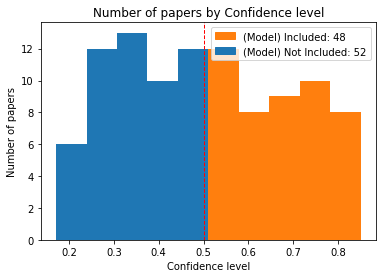

In [ ]:
interface = Interface(resultWEB.data)
interface()

## Usando `SearcherAPI()`



------------------------------------------------------------------------------------------
Unlabeled: 81 (58.7%)
Labaled 57 (41.3%)
  Not included examples: 42 (30.43%)
  Included examples: 15 (10.87%)
------------------------------------------------------------


index: 4
Label: Included
Text:


Boosting Offline Handwritten Text Recognition in Historical Documents With Few Labeled Lines. In this paper we address the problem of offline handwritten text recognition (HTR) in historical documents when few labeled samples are available and some of them contain errors in the train set. Our three main contributions are: first, we analyze how to perform transfer learning (TL) from a massive database to a smaller historical database, analyzing which layers of the model need fine-tuning. Second, we analyze methods to efficiently combine TL and data augmentation (DA). Finally, we propose an algorithm to mitigate the effects of incorrect labeling in the training set. The methods are analyzed over the ICFHR 2018 competition database, Washington and Parzival. Combining all these techniques, we demonstrate a remarkable reduction of CER (up to 6 percentage points in some cases) in the test set with little complexity overhead.

Confidence: 0.7874009
(Model) Included: True
------------------------------------------------------------


------------------------------------------------------------------------------------------


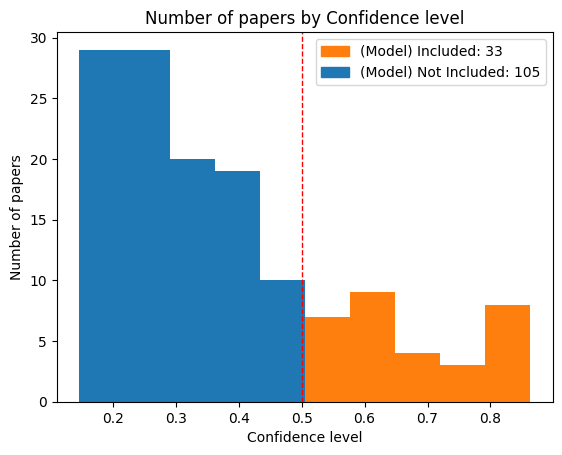

In [10]:
interface = Interface(resultAPI.data_article) # data_article após clicar Export Articles
interface()

## Exemplo usando outra fonte de dados (pseudo-code)

In [ ]:
# Load data from another source
data_test = pd.read_csv('/content/SLRdata_test.csv')
data_train = pd.read_csv('/content/SLRdata_train_valid.csv')
data = pd.concat([data_train,data_test])

# Rename column with SLR decisions
data= data.rename(columns= {'decision':'label'})
# Reset index
data = data.reset_index()

In [ ]:
interface = Interface(data)
interface()

# Salvar no Google Sheets

`spreadsheet_name` é o nome da planilha no [Google Sheets](https://workspace.google.com/intl/pt-BR/products/sheets/?utm_source=google&utm_medium=cpc&utm_campaign=latam-BR-all-pt-dr-skws-all-all-trial-e-dr-1011272-LUAC0011922&utm_content=text-ad-none-any-DEV_c-CRE_477535134213-ADGP_Hybrid%20%7C%20SKWS%20-%20EXA%20%7C%20Txt%20~%20Sheets_Spreadsheet-KWID_43700057667741410-kwd-11653031&utm_term=KW_spreadsheet-ST_spreadsheet&gclid=CjwKCAjw14uVBhBEEiwAaufYxz27yUv1PZLO_b-y4VyhQ0oc6l0XJLJAnImPGs4EYi-8uJD-VsR3bxoCZCkQAvD_BwE&gclsrc=aw.ds) salva na conta de login de autenticação após executar a célula usando o caminho passado em `data_path`.

In [ ]:
#@title Título da planilha
spreadsheet_name = "SLR_AI_DECISION" #@param {type:"string"}
data_path = "data.csv" #@param {type:"string"}

from google.colab import auth
import gspread
from gspread import Cell
import gspread_dataframe
from google.auth import default

# authentication
auth.authenticate_user()
creds, _ = default()
gc = gspread.authorize(creds)

# load spreadsheet
gc.create(spreadsheet_name)
wd = gc.open(spreadsheet_name)
url=  wd.fetch_sheet_metadata()['spreadsheetUrl']
sheet = wd.get_worksheet(0)

# Save
data = pd.read_csv(data_path)
gspread_dataframe.set_with_dataframe(sheet, data)


print(url)

## Carregar planilha

In [ ]:
#@title Título da planilha
spreadsheet_name = "SLR_IA_DECISION" #@param {type:"string"}

In [ ]:
wd= gc.open(spreadsheet_name)
sheet = wd.get_worksheet(0)
data = sheet.get_all_records()
data = pd.DataFrame(data)

data.head()

# BibTeX (EXTRA)

Se o banco de dados de artigos tiver DOI, a seguinte função pode recuperar a citação no formato BibTeX.

In [ ]:
def doi2bib(doi):
    """
    Return a bibTeX string of metadata for a given DOI.
    """

    url = "http://dx.doi.org/" + doi

    headers = {"accept": "application/x-bibtex"}
    r = requests.get(url, headers = headers)

    return r.text


doi2bib(doi)